# Lab 6

For the LHC data, we are going to have to fake a background. Make a Poisson background with mean 100.

In [1]:
# imports
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import poisson

In [2]:
events = np.arange(0, 200)
mean = 100

distribution = poisson.pmf(events, mean)

## Problem 1

The first problem is to look at your background distribution and determine where the 5σ sensitivity threshold is. [Hint, you've done this several times now, look back at the first few labs.]

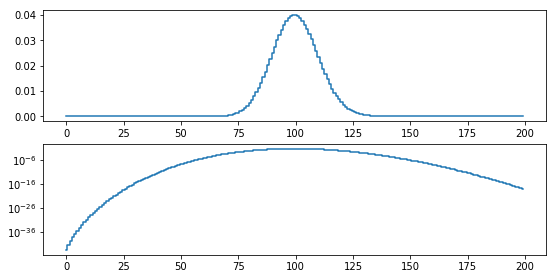

In [3]:
figure = plt.figure(figsize=(9, 4.5))
axes = figure.subplots(2, 1)

axes[0].step(events, distribution, where='mid')
axes[1].step(events, distribution, where='mid')
axes[1].set_yscale('log')

In [4]:
sigma5detection = 1/3.5e6
measurement_hi = poisson.ppf(1-sigma5detection, mean)
measurement_lo = poisson.ppf(sigma5detection, mean)

print(measurement_hi)
print(measurement_lo)

154.0
54.0


My 5 sigma detections are 154 on the upper boundary and 54 on the lower boundary. Measurements outside of these values are outside of 5 sigma probability from the mean.

## Problem 2
Now create a set of injected (simulated) signals of a single strength. You will want to make your signal moderately strong, say somewhere in the 8-30σ  range. Inject this signal into your background data many times.

### 2a.
Histogram how bright the observed signal appears to be and discuss it's shape. Say in words what this histogram is telling you.

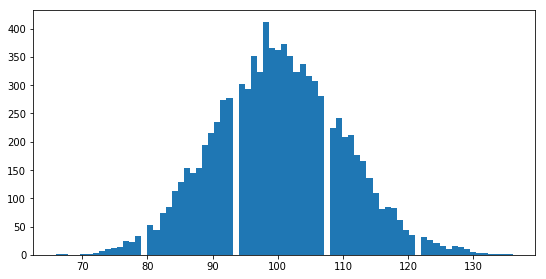

In [5]:
# Lets construct a background signal
signal_probability = 0.1
data_points = 10000

# calculated constants
sig_points = int(data_points * signal_probability)
back_points = data_points - sig_points

back_signal = poisson.rvs(mean, size=back_points)

figure = plt.figure(figsize=(9, 4.5))
ax = figure.subplots()
ax.hist(back_signal, bins=75);

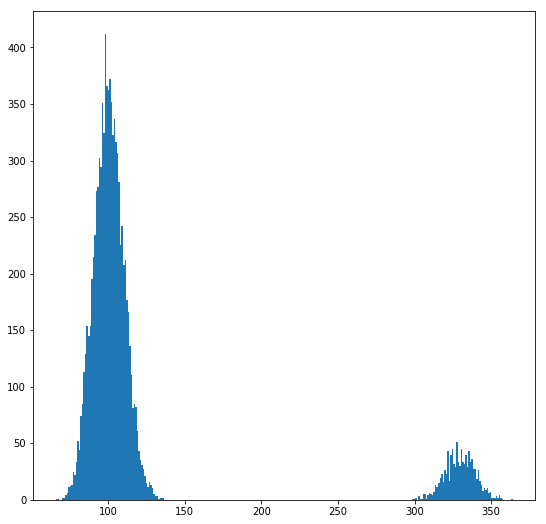

In [6]:
# Injected signal
inject_value = 230

inject_signal = np.add(np.ones(sig_points) * inject_value, 
                       poisson.rvs(mean, size=sig_points))
obs_signal = np.append(back_signal, inject_signal)

figure = plt.figure(figsize=(9, 9))
ax = figure.subplots()
ax.hist(obs_signal, bins=300);

Our observed signal is going to appear very dim because of the number of background points we get. The histogram tells me it is most likely to get a background value.

### 2b.
Is your observed signal biased? (e.g. is the observed value equally likely to be stronger or weaker than the true injected signal?) Is it symmetric?

The observed signal is biased. It is far more likely to measure lower than a true injected signal, because most measurements are going to be that of the background. It is decidedly asymmetric.

## Problem 3
Now make a suite of injected signals. You will want to have a range of injected signal strengths, starting at zero and extending well above 5 sigma (30 sigma or more).

### 3a.
Clearly state what you are simulating, and make a 2D histogram of injected signal vs. observed signal.

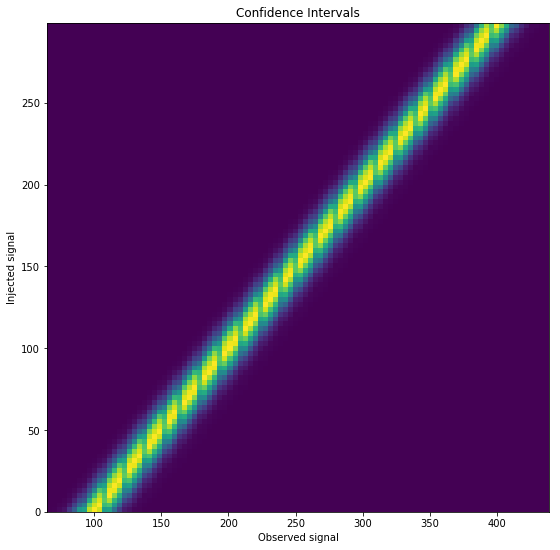

In [19]:
# I give up, I guess I'll show addition working.
strengths_num = 300
noise_num = 10000

signal_strength = np.arange(0, strengths_num)
signal = np.repeat(np.meshgrid(signal_strength), noise_num, axis=0)
# print(signal, '\n')

# reshape distribution to force a 2d array
noise = np.reshape(poisson.rvs(mean, size=noise_num), (noise_num, 1))
noise = np.repeat(noise, strengths_num, axis=1)
# print(noise, '\n')

observed = np.add(noise, signal)
# print(observed, '\n')

#have to flatten for 2d histograms
x_axis = np.reshape(observed, (noise_num * strengths_num, 1))
y_axis = np.reshape(signal, (noise_num * strengths_num, 1))
# print(x_axis.shape, '\n', x_axis, '\n')
# print(y_axis.shape, '\n', y_axis, '\n')

figure = plt.figure(figsize=(9, 9))
ax = figure.subplots()

ax.set_title("Confidence Intervals")
ax.set_ylabel("Injected signal")
ax.set_xlabel("Observed signal")


ax.hist2d(np.squeeze(x_axis), np.squeeze(y_axis), bins=100);

This histogram simulates the injected simulation values, where the whole background is altered by the true signal in our observation. If the true signal only affected some fraction of the background signal, we would see a band of probability up around an observed signal of 100, because that is the mean of the background data. I didn't show that here because I was having a really hard time getting the code to play nicely. The dark vertical bands are an artifact of how matplotlib automatically divides the bins in the histogram visualization, and have no physical meaning.

### 3b.
If you choose the same injected signal power as in problem 2, show that you get the same answer.

I mean, this is kinda redundant since I am just showing that adding a signal that affects all background will create a signal that is background plus the signal strength. So, I guess the answer is just the following.

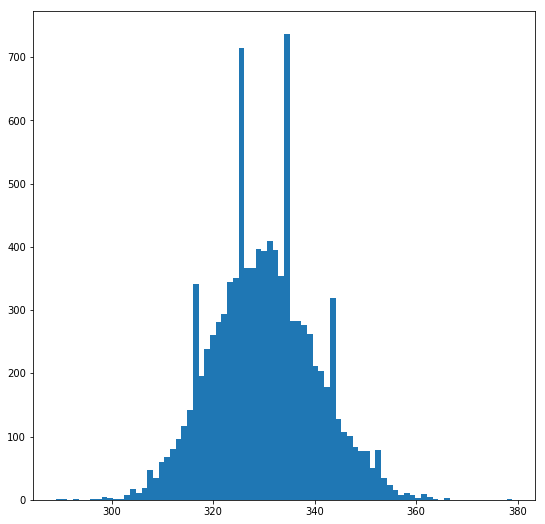

In [8]:
observed_signal = np.add(np.ones(10000) * inject_value, 
                        poisson.rvs(mean, size=10000))

figure = plt.figure(figsize=(9, 9))
ax = figure.subplots()

ax.hist(observed_signal, bins=80);

This looks how I would expect, having all background points affected instead of just 10% like I showed in problem 2. Now the left bump from problem 2 is large and the background bump is non-existent. 

### 3c.
Now reverse the problem, select an observed signal (pick something quite a bit stronger than 5 sigma) and create a 1D histogram of the injected signal pdf(). Describe the meaning of this histogram.

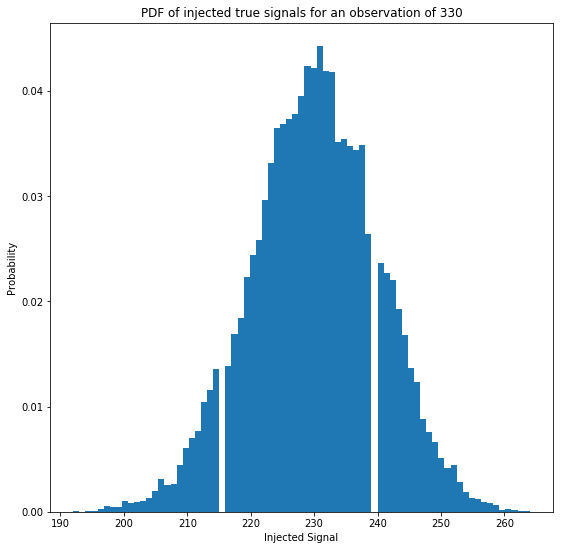

In [9]:
# consistency
observe_signal = 330

# Want to see a vertical slice of injected signals for this value
# This will result in all the "true" signals capable of providing this
# reading.

# get signal if the observation is desirable, zero if not
filtered_observation = np.where(observed == observe_signal, signal, 0)
injected_pdf = filtered_observation[np.nonzero(filtered_observation)]

figure = plt.figure(figsize=(9, 9))
ax = figure.subplots()

n, bins, patches = ax.hist(injected_pdf, bins=75, density=True);
ax.set_title("PDF of injected true signals for an observation of " +
            str(observe_signal));
ax.set_ylabel("Probability");
ax.set_xlabel("Injected Signal");

This is what I would expect. This histogram shows us what the most probable true signal would be for this observation, with the shape around the mean indicating how likely the other true signal values are to give this observation.

### 3d.
For your observed signal, what is the 1 sigma uncertainty on the true signal strength?

In [10]:
# Since this is set to be a density function, I should have values for
# all of the bins in terms of a probability. 1 sigma probability is 68%,
# so I will add values of n, starting at the mean, until the probability 
# (or sum of these values) is greater than or equal to 0.68, at which
# point I will find the bins value for these indices.

sigma_probability = .68

# True mean is 230, numerical mean will be the bin with the highest n value
mean_idx = n.argmax()
numerical_mean = bins[mean_idx]

probability = n[mean_idx] # the center

# Find upper bound
upper_bound = numerical_mean
for idx in range(mean_idx, len(bins)):
    if probability < sigma_probability / 2:
        probability += n[idx]
    else:
        # for upper_bound, mean_idx + idx is the left edge of the 
        # last added bin. We want the right edge, so
        upper_bound = bins[idx + 1]
        # Job finished, stop looping
        break
        
# reset probability
probability = n[mean_idx]

# Find lower bound
lower_bound = numerical_mean
for idx in range(mean_idx, 0, -1):
    if probability < sigma_probability / 2:
        probability += n[idx]
    else: 
        lower_bound = bins[idx]
        break
        

print("The upper and lower bounds of 1 sigma uncertainty are " 
      + str(upper_bound) + " and " 
      + str(lower_bound) + " respectively.")

The upper and lower bounds of 1 sigma uncertainty are 239.04 and 222.72 respectively.


### 3e.
Discuss the answer to part d in some depth. Is it symmetric? Is it biased? Does this make sense?

In [11]:
plus_difference = upper_bound - numerical_mean
minus_difference = numerical_mean - lower_bound
print(plus_difference, minus_difference)

8.639999999999986 7.680000000000007


The differences from boundary to mean for the upper and lower boundary are similar enough to call the answer in d symmetric and unbiased. This makes sense because we shifted our entire signal up to around the injected signal. If we had an observation where some high percentage was the base noise and some was the true signal, then we would see some asymmetric uncertainty and bias towards the lower bound, especially for lower observed signal values. This is because the majority of measurements would be from background, which is lower than the values for true signal. The density of these background values would be high, so the 1 sigma would be much closer to the mean than the upper boundary would be.

## Problem 4
Using the same setup as in problem 3, now pick a relatively weak signal (say in the 1 sigma range, exact strength not important).


### 4a.
Repeat problem **3c**, calculating the injected signal pdf(). One of the differences you should immediately see is that the pdf() extends to zero.

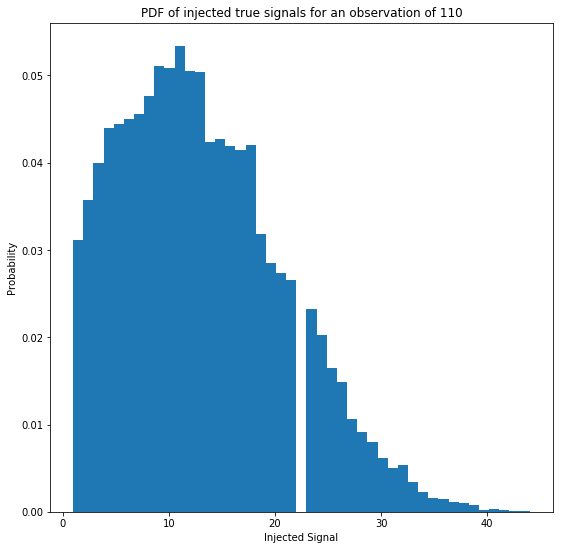

In [12]:
offset = mean
observe_signal = 10 + offset

# get signal if the observation is desirable, zero if not
filtered_observation = np.where(observed == observe_signal, signal, 0)
injected_pdf = filtered_observation[np.nonzero(filtered_observation)]

figure = plt.figure(figsize=(9, 9))
ax = figure.subplots()

n, bins, patches = ax.hist(injected_pdf, bins=45, density=True);
ax.set_title("PDF of injected true signals for an observation of " +
            str(observe_signal));
ax.set_ylabel("Probability");
ax.set_xlabel("Injected Signal");

### 4b.
Describe what it means to have the true signal pdf() extend to zero.

If true signal pdf extends to zero, that means that it is possible for the observed value to be due entirely to background noise.

### 4c.
Calculate a 95% confidence upper bound. [Hints: make sure your pdf() is normalized. The statistical question is: if I observe this candidate signal (and it is too weak to claim a detection), then the true signal would be less than *X* 95% of the time.]

In [13]:
# n gives me the probabilities for each bin
# bins gives me the left edge of each bin
# since n is normalize, add n until >= .95, and find bin edge for that idx

probability = 0
upper_bound = 0
for idx in range(0, len(n)):
    if probability < 0.95:
        # add probability, move on
        probability += n[idx]
    else:
        # idx is index of the farthest right bins' left edge
        # want the right edge since this bin was added, so
        upper_bound = bins[idx + 1]
        # and want to stop looping since we found what we want
        break

print("The " + str(probability * 100) + 
      " percent confidence upper bound is " + str(upper_bound))

The 95.79413160613083 percent confidence upper bound is 25.844444444444445


The percentage isn't exact due to the rounding of the bin sizes. Although this is a density function, the sum of the bins values is actually about 1.02